<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import numpy as np
import pandas as pd

import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

import nltk
from tqdm.notebook import tqdm

from nltk.corpus import stopwords as nltk_stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score

from sklearn.utils import shuffle

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')


Подгрузили все необходимые библиотеки и инструменты.

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [3]:
data.sample(20)

,Unnamed: 0,text,toxic
8621,8633,"harmony between people of this village, or may...",0
9307,9320,"Bernstein, P. L. 1996. Against the gods: the r...",0
20690,20710,EK728 \n\nHey EkoGraf its EK728 when you get a...,0
100012,100109,"""\n\nFormat\nCan we put aside the Hobbins mudf...",0
156294,156453,Personal thank you and FAR begging \n\nMalleus...,0
46378,46433,"wow, wonderful work! keep digging up academic ...",0
36428,36470,go on with the map EHT and without a doubt put...,0
64717,64784,It is here. - (talk),0
58073,58137,"­­ \nYeah, revert my edit, you conformist.",0
99383,99479,"""\n\n(cur) (last) 23:14, 2 May 2007 Parjay (T...",1


In [4]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Загрузили и посмотрели данные

In [5]:
corpus = list(data['text'])

In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [8]:
lemmatizer = WordNetLemmatizer()

In [9]:
def clear_text(text):
    text = text.lower()
    y=re.sub(r"[^'a-zA-Z ]", ' ', text) 
    k=" ".join(y.split())
    return k

In [10]:
data['text'] = data['text'].apply(clear_text)

In [11]:
data.sample(10)

,Unnamed: 0,text,toxic
99875,99972,years ago then the sphinx was in better form t...,0
144694,144850,get rid of editors who are runing this site an...,0
68962,69030,you can't sweep falsehoods underneath the rug ...,0
77497,77573,don't be stupid then,1
43683,43736,this is very non notable as related to the arc...,0
83503,83582,i took terri to mediplex in bradenton fla a re...,0
137673,137820,categories hey these categories you're adding ...,0
27622,27659,israeli apartheid article look here and explai...,0
93056,93148,rose's surname should be capitalized in the pa...,0
22313,22333,this also applies to all your other image uploads,0


In [12]:
from nltk.corpus import wordnet
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

Создали функцию по очистке данных

In [13]:
test = "The striped bats are hanging on their feet for best"
print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(test)])

['The', 'strip', 'bat', 'be', 'hang', 'on', 'their', 'foot', 'for', 'best']


Очистили и проверили

In [14]:
def lemmafunction(textc):
    k=[]
    for i in nltk.word_tokenize(textc):
        y=lemmatizer.lemmatize(i, get_wordnet_pos(i))
        k.append(y)
    return ' '.join(k) 




In [15]:
%%time
from tqdm.notebook import tqdm
tqdm.pandas()
data['text'] = data['text'].progress_apply(lemmafunction)

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 16min 38s, sys: 1min 46s, total: 18min 24s
Wall time: 18min 48s


Создадали функцию которая будет использовать функцию по очистке слов и лемматизировать каждое слово

Преобразовали текст

In [16]:
data['text'][3]

"more i ca n't make any real suggestion on improvement i wonder if the section statistic should be later on or a subsection of type of accident i think the reference may need tidy so that they be all in the exact same format ie date format etc i can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let me know there appear to be a backlog on article for review so i guess there may be a delay until a reviewer turn up it 's list in the relevant form eg wikipedia good article nomination transport"

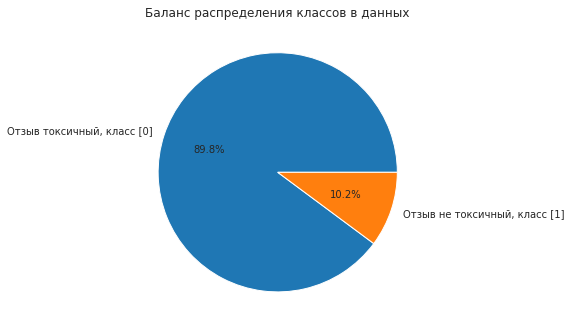

In [17]:
sns.set_style('darkgrid')
data['toxic'].value_counts(normalize=True).plot(kind='pie',figsize=[5.5,5.5], legend=False, autopct='%1.1f%%',labels=['Отзыв токсичный, класс [0]','Отзыв не токсичный, класс [1]'])
plt.title('Баланс распределения классов в данных')
#plt.xlabel('Класс')
plt.ylabel('')
plt.show()

Посмотрели распределение класов

In [18]:
X=data.drop('toxic',axis=1)
y=data['toxic']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True,stratify=y)

In [20]:
train_sample=X_train.shape[0]/X.shape[0]
test_sample=X_test.shape[0]/X.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(train_sample))
print('Размер тестовой выборки - {:.0%}'.format(test_sample))

Размер тренировочной выборки- 75%
Размер тестовой выборки - 25%


Разделили данные на признаки и целевой признак, разбили выборки, проверили.

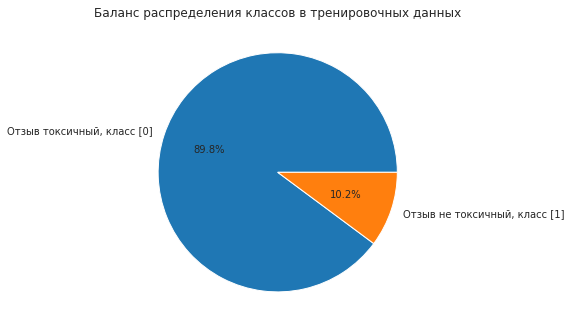

In [21]:
y_train.value_counts(normalize=True).plot(kind='pie',figsize=[5.5,5.5], legend=False, autopct='%1.1f%%',labels=['Отзыв токсичный, класс [0]','Отзыв не токсичный, класс [1]'])
plt.title('Баланс распределения классов в тренировочных данных')
plt.ylabel('')
plt.show()

Распределение классов в тренировочной выборке

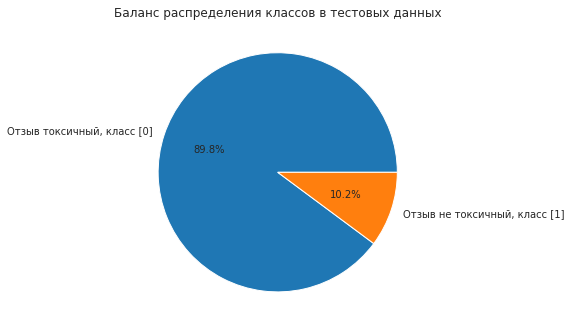

In [22]:
y_test.value_counts(normalize=True).plot(kind='pie',figsize=[5.5,5.5], legend=False, autopct='%1.1f%%',labels=['Отзыв токсичный, класс [0]','Отзыв не токсичный, класс [1]'])
plt.title('Баланс распределения классов в тестовых данных')
plt.ylabel('')
plt.show()

Распределение классов в тестовой выборке

Проверили

In [23]:
nltk.download('stopwords') 
stop_words = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Загрузили библиотеку и стоп-слова из английского языка

In [24]:
corpus_lemm_train = X_train['text'].values
corpus_lemm_train.shape

(119469,)

Создадали корпус из лемматизированных и очищенных слов

In [25]:
%%time
count_tf_idf = TfidfVectorizer(stop_words=stop_words,analyzer='word') 
tf_idf = count_tf_idf.fit_transform(corpus_lemm_train) 
tf_idf.shape

CPU times: user 5 s, sys: 106 ms, total: 5.11 s
Wall time: 5.14 s


(119469, 127764)

Применли модель TfidfVectorizer и обучили её на наших тренировочных данных

In [26]:
corpus_lemm_test = X_test['text'].values
corpus_lemm_test.shape

(39823,)

Создадали так же корпус слов и для тестовой выборки

In [27]:
%%time
tf_test = count_tf_idf.transform(corpus_lemm_test)
tf_test.shape

CPU times: user 1.64 s, sys: 6.42 ms, total: 1.65 s
Wall time: 1.66 s


(39823, 127764)

Трансформировали тестовую выборку

<strong>Вывод:</strong>
При ознакомлении с данными мы обнаружили, что они очень сильно разбалансированы в сторону негативного класса. 

## Обучение

In [28]:
def highlight_min(data, color='red'):
    attr = 'color: {}'.format(color)
    if data.ndim == 1:
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [29]:
def create_colors(x):
    df1 = x.copy()
    df1.loc[:,:] = 'background-color: '
    df1.loc['Predicted Positive(1)', 'Actually Negative(0)'] = 'background-color: coral'
    df1.loc['Predicted Negative(0)', 'Actually Positive(1)'] = 'background-color: coral' 
    df1.loc['Predicted Positive(1)', 'Actually Positive(1)'] = 'background-color: springgreen'
    df1.loc['Predicted Negative(0)','Actually Negative(0)'] = 'background-color: springgreen'

    return df1      

In [30]:
def conf_marix(predict):
    table=pd.DataFrame(index=['Predicted Positive(1)','Predicted Negative(0)',], columns=['Actually Positive(1)','Actually Negative(0)','Difference'])
    matrix=confusion_matrix(y_test, predict)
    table['Actually Positive(1)']['Predicted Positive(1)']= 'TP  {:.0f}'.format(matrix[0][0])
    table['Actually Positive(1)']['Predicted Negative(0)']= 'FN   {:.0f}'.format(matrix[1][0])

    table['Actually Negative(0)']['Predicted Positive(1)']= 'FP  {:.0f}'.format(matrix[0][1])
    table['Actually Negative(0)']['Predicted Negative(0)']= 'TN  {:.0f}'.format(matrix[1][1])
    
    table['Difference'][0] = abs(matrix[0][0] - matrix[0][1])
    table['Difference'][1] = abs(matrix[1][1]- matrix[1][0])
    return table.style.apply(create_colors, axis=None).apply(highlight_min, subset=['Difference'])

<strong>LogisticRegression</strong>

In [31]:
%%time

clf_lr = LogisticRegression(random_state=12345, solver='sag',class_weight='balanced')
parametrs_lr = { 'C': range (1, 10),
              'max_iter': range (10,15,2),
              }
grid_lr = GridSearchCV(clf_lr, parametrs_lr, cv=3, scoring='f1')
grid_lr.fit(tf_idf, y_train)
print('Лучшие параметры модели "LogisticRegression" равны :',grid_lr.best_params_)
print('Метрика F1 качества предсказания модели "LogisticRegression" равна :',grid_lr.best_score_)

Лучшие параметры модели "LogisticRegression" равны : {'C': 4, 'max_iter': 14}
Метрика F1 качества предсказания модели "LogisticRegression" равна : 0.753033070127293
CPU times: user 1min 19s, sys: 661 ms, total: 1min 19s
Wall time: 1min 19s


<strong>LGBMRegressor</strong>

In [32]:
    model = LGBMRegressor()
    params = {
        'boosting_type' : ['gbdt'],
        'n_estimators' : [50, 100],
        'max_depth' : [5, 7, 10],
        'verbose' : [10],        
        'random_state' : [12345],
        'force_col_wise': [True],
        'num_leaves' : [127]}
    grid_cv = GridSearchCV(model, params, cv=3, n_jobs=-1, scoring='f1')
    grid_cv.fit(tf_idf, y_train)
    print('Лучшие параметры модели "LGBMRegressor" равны :',grid_cv.best_params_)
    print('F1 LGBMRegressor =', grid_cv.best_score_)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.996839
[LightGBM] [Info] Total Bins 392927
[LightGBM] [Info] Number of data points in the train set: 79646, number of used features: 7506
[LightGBM] [Info] Start training from score 0.100821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further spli

Лучше всего себя показала линейная регрессия

Проверим лучшую модель на тестовой выборке.

In [34]:
%%time

clf_lr = LogisticRegression(random_state=12345, solver='sag',class_weight='balanced')
parametrs_lr = { 'C': range (1, 10),
              'max_iter': range (10,15,2),
              }
grid_lr = GridSearchCV(clf_lr, parametrs_lr, cv=3, scoring='f1')
grid_lr.fit(tf_idf, y_train)
predictions_test = grid_lr.predict(tf_test)
print('финальный F1 LogisticRegression =', grid_lr.best_score_)

финальный F1 LogisticRegression = 0.753033070127293
CPU times: user 1min 16s, sys: 478 ms, total: 1min 17s
Wall time: 1min 17s


## Выводы

Логистическая регрессия показала себя лучше. На тесте подтвердила метрику.

<h1>Общий вывод:</h1>

Нашей целью было найти и обучить модель для магазина "ВИКИШОП", которая способна классифицировать комментарии на позитивные и негативные для того, чтобы в дальнейшем токсичные отзывы отправлялись на модерацию. При этом достигуть результата предсказания наилучшей модели по мерке f1 не меньше 0.75 


В нашем распоряжении был набор данных с разметкой о токсичности правок, но для правильной работы предсказательных алгоритмов моделей нам пришлось очистить комментарии от лишних символов и пр.мусора, а так же прибегнуть к балансировке выборок методами upsample и downsamle, т.к. сильный дисбаланс в классах мог негативно повлиять на качество предсказания моделей.

Для определения наилучшей модели мы остановили наш выбор на трёх моделях DecisionTreeClassifier,LogisticRegression и RandomForestClassifier. По итогам сравнеиня победила модель LogisticRegression и после подбора порогового значения, набрала значение метрики f1=0.77


Таким образом мы справились с поставленной задачей и для магазина "ВИКИШОП" можем смело рекомендовать к использованию в своей работе нашу модель!